## compare sleep score calculated by Rockelle and Maya's method

In [18]:

import numpy as np
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from utils.csc_reader import load_mat_file


In [55]:
def downsample_sleep_score(sleep_score_vec: np.ndarray, original_sr: int = 2000, bin_size: int = 30) -> np.ndarray:
    """Downsample sleep_score_vec to bins of 30 seconds based on given rules."""
    
    sleep_score_vec = sleep_score_vec.squeeze()
    samples_per_bin = original_sr * bin_size
    # num_bins = int(np.ceil(sleep_score_vec.shape[0] / samples_per_bin))
    num_bins = sleep_score_vec.shape[0] // samples_per_bin

    downsampled = np.zeros(num_bins, dtype=int)
    for i in range(num_bins):
        start_index = i * samples_per_bin
        end_index = min(start_index + samples_per_bin, sleep_score_vec.shape[0])
        
        bin_values = sleep_score_vec[start_index : end_index]
        unique, counts = np.unique(bin_values, return_counts=True)
        bin_dict = dict(zip(unique, counts))
        
        if -1 in bin_dict and bin_dict[-1] > bin_dict.get(1, 0):
            downsampled[i] = -1
        elif 1 in bin_dict and bin_dict[1] > bin_dict.get(-1, 0):
            downsampled[i] = 1
    
    return downsampled


def plot_sleep_stages(sleep_scores: np.ndarray) -> None:
    """
    Plots sleep stages based on a NumPy array of sleep scores.

    Args:
        sleep_scores (np.ndarray): A NumPy array of sleep scores where:
            -1.0 represents REM,
            1.0 represents non-REM,
            0.0 represents Other.
    """
    # Define the colors and labels for each sleep stage
    colors: Dict[float, str] = {-1.0: 'blue', 1.0: 'green', 0.0: 'red'}
    labels: Dict[float, str] = {-1.0: 'REM', 1.0: 'non-REM', 0.0: 'Other'}
    
    # Create a time axis (assuming each score corresponds to a 30-second epoch)
    time: np.ndarray = np.arange(len(sleep_scores)) * 30 / 60  # Convert to minutes
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Plot each sleep stage as a block (without edge color)
    for i, score in enumerate(sleep_scores):
        ax.barh(0, width=0.5, height=1, left=time[i], color=colors[score])
    
    # Set labels and title
    ax.set_xlabel('Time (minutes)')
    ax.set_yticks([])  # Hide y-axis ticks
    ax.set_title('Sleep Stages')
    
    # Create legend
    legend_elements: list[plt.Rectangle] = [
        plt.Rectangle((0, 0), 1, 1, color=colors[score], label=labels[score]) 
        for score in colors
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Show the plot
    plt.show()


def plot_two_sleep_stages(sleep_scores_1: np.ndarray, sleep_scores_2: np.ndarray, labels: List[str]) -> None:
    """
    Plots two sleep scores stacked vertically with labels.

    Args:
        sleep_scores_1 (np.ndarray): First sleep score array.
        sleep_scores_2 (np.ndarray): Second sleep score array.
        labels (List[str]): Labels for the two sleep scores (e.g., ['Subject 1', 'Subject 2']).
    """
    # Define the colors and labels for each sleep stage
    colors: Dict[float, str] = {-1.0: 'blue', 1.0: 'green', 0.0: 'red'}
    stage_labels: Dict[float, str] = {-1.0: 'REM', 1.0: 'non-REM', 0.0: 'Other'}
    
    # Create a time axis (assuming each score corresponds to a 30-second epoch)
    time: np.ndarray = np.arange(len(sleep_scores_1)) * 30 / 60  # Convert to minutes
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 3))
    
    # Plot the first sleep score
    for i, score in enumerate(sleep_scores_1):
        ax.barh(0, width=0.5, height=1, left=time[i], color=colors[score], edgecolor='none')
    
    # Plot the second sleep score
    for i, score in enumerate(sleep_scores_2):
        ax.barh(1, width=0.5, height=1, left=time[i], color=colors[score], edgecolor='none')
    
    # Set labels and title
    ax.set_xlabel('Time (minutes)')
    ax.set_yticks([0, 1])  # Set y-ticks to correspond to the two sleep scores
    ax.set_yticklabels(labels)  # Add labels for the two sleep scores
    ax.set_title('Sleep Stages Comparison')
    
    # Create legend for sleep stages
    legend_elements: List[plt.Rectangle] = [
        plt.Rectangle((0, 0), 1, 1, color=colors[score], label=stage_labels[score]) 
        for score in colors
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    

def plot_contingency_matrix(
    sleep_scores_1: np.ndarray, 
    sleep_scores_2: np.ndarray, 
    method_labels: List[str]
) -> None:
    """
    Calculates and visualizes the contingency matrix of two sleep scores, ignoring elements with 0 ('Other').
    Adds precision, recall, and F1 score to the plot.

    Args:
        sleep_scores_1 (np.ndarray): First sleep score array.
        sleep_scores_2 (np.ndarray): Second sleep score array.
        method_labels (List[str]): Labels for the sleep score methods (e.g., ['Method A', 'Method B']).
    """
    # Filter out elements where either score is 0
    mask = (sleep_scores_1 != 0) & (sleep_scores_2 != 0)
    filtered_scores_1 = sleep_scores_1[mask]
    filtered_scores_2 = sleep_scores_2[mask]

    # Calculate the contingency matrix
    value_labels = ['REM', 'non-REM']  # Labels for -1 and 1
    cm = confusion_matrix(filtered_scores_1, filtered_scores_2, labels=[-1, 1])

    # Calculate metrics
    precision = precision_score(filtered_scores_1, filtered_scores_2, labels=[-1, 1], average='weighted')
    recall = recall_score(filtered_scores_1, filtered_scores_2, labels=[-1, 1], average='weighted')
    f1 = f1_score(filtered_scores_1, filtered_scores_2, labels=[-1, 1], average='weighted')

    # Create a heatmap for visualization
    plt.figure(figsize=(5, 3))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=value_labels, 
        yticklabels=value_labels
    )
    plt.xlabel(method_labels[1])  # Label for sleep_scores_2
    plt.ylabel(method_labels[0])  # Label for sleep_scores_1
    plt.title('Contingency Matrix (Ignoring "Other")', fontsize=10)

    # Add metrics to the plot
    metrics_text = f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}'
    plt.text(
        x=1.3, 
        y=0.7, 
        s=metrics_text, 
        ha='left', 
        va='bottom', 
        transform=plt.gca().transAxes, 
        bbox=dict(facecolor='white', alpha=0.8)
    )

    plt.tight_layout()
    plt.show()


def load_sleep_score(file_name: str) -> np.ndarray:
    """
    Reads the first column of a .csv file, ignores the header, and maps values:
    - 'Wake/REM' to -1
    - All other values to 1.

    Args:
        file_path (str): Path to the .csv file.

    Returns:
        np.ndarray: A NumPy array of integer values.
    """
    
    # Read the first column of the .csv file, skipping the header
    df = pd.read_csv(file_name, usecols=[0], header=None, skiprows=1)

    # Map 'Wake/REM' to -1 and all other values to 1
    mapped_values = df[0].apply(lambda x: -1 if x.strip() == 'Wake/REM' else 1)

    # Convert the mapped values to a NumPy array of integers
    return mapped_values.to_numpy()

    

In [56]:

sleep_score_file = ('/Users/XinNiuAdmin/HoffmanMount/data/PIPELINE_vc/ANALYSIS/MovieParadigm/'
                    '566_MovieParadigm/Experiment-8/sleep_score/sleepScore_ROF2_001.mat')

sleep_score_rockelle = ('/Users/XinNiuAdmin/Library/CloudStorage/Box-Box/Vwani_Movie/sleep scoring/'
                        'EXP8_Movie24&566_firstpass.csv')


data = load_mat_file(sleep_score_file)
sleep_score_maya = downsample_sleep_score(data['sleep_score_vec'])

sleep_score_rockelle = load_sleep_score(sleep_score_rockelle)

/Users/XinNiuAdmin/Documents/MATLAB/nwbPipeline/src/utils/csc_reader.py:303: UserWarning: /Users/XinNiuAdmin/HoffmanMount/data/PIPELINE_vc/ANALYSIS/MovieParadigm/566_MovieParadigm/Experiment-8/sleep_score/sleepScore_ROF2_001.mat is not in MATLAB 7.3 format, loading with scipy.io.loadmat
  warnings.warn(f"{filename} is not in MATLAB 7.3 format, loading with scipy.io.loadmat")


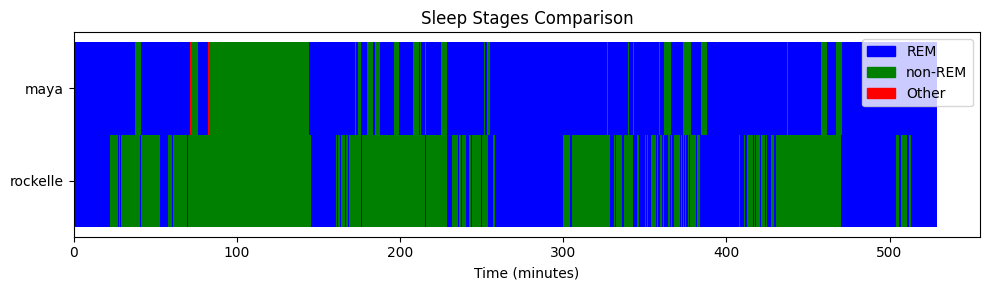

In [57]:
plot_two_sleep_stages(sleep_score_rockelle, sleep_score_maya, ['rockelle', 'maya'])

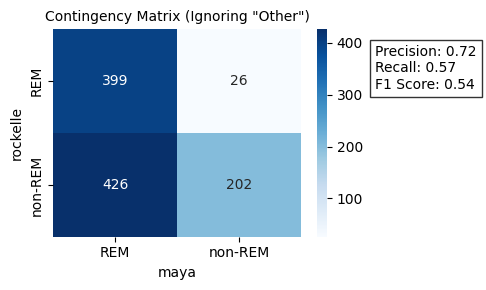

In [58]:
plot_contingency_matrix(sleep_score_rockelle, sleep_score_maya, ['rockelle', 'maya'])